In questo notebook, vengono riportati i calcoli effettuati sia sul Cucker-Smale classico e sia sul Cucker-Smale ridefinito, utilizzando le formule riporate nella relazione del progetto e stampando i relativi grafici.
Per una computazione più veloce i valori delle posizioni e delle velocità di ogni singolo uccello ad ogni instante di tempo vengono lette dirattamente dai file di testo precedentemente costruiti su un numero diverso di uccelli, steps e parametri principali.

In [10]:
#Importo librerie utili al programma
import numpy as np
import random as rd
import math as mp
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import csv
import seaborn as sns

In [11]:
#per far si che funzioni correttamente bisogna installare SciencePlots tramite 'pip install SciencePlots'

plt.style.use(['science', 'notebook', 'grid'])

Le variabili utili al programma non sono parametri fissi, ma vengono cambiate in base ai parametri, uccelli e steps
utilizzati nelle simulazioni per la costruzione dei file di testo

In [12]:
#Variabili utili al programma
modello   =  "ridefinito"
steps     =  14
birds     =  100
beta      =   0.5
ndim      =   3
view_step =  steps -1

Funzione per la quantificazione dell'anisotropia dello stormo. Restituisce il seguente risultato:

![Anisotropia](Img/anisotropia.png)

In [13]:
def anisotropia(vel, pos):
    position = pos
    veloc = vel
    mini = 200
    matrix = np.zeros((birds, 3, 3))
    for i in range(birds):
        for j in range(birds):
            if i != j:
                val = np.linalg.norm(position[i] - position[j])
                if val < mini:
                    jmin = j
                    mini = val
        ui = (veloc[i] / np.linalg.norm(veloc[i]))
        uj = (veloc[jmin] / np.linalg.norm(veloc[jmin]))
        matrix[i][0][0] = ui[0] * uj[0]
        matrix[i][0][1] = ui[0] * uj[1]
        matrix[i][0][2] = ui[0] * uj[2]
        matrix[i][1][0] = ui[1] * uj[0]
        matrix[i][1][1] = ui[1] * uj[1]
        matrix[i][1][2] = ui[1] * uj[2]
        matrix[i][2][0] = ui[2] * uj[0]
        matrix[i][2][1] = ui[2] * uj[1]
        matrix[i][2][2] = ui[2] * uj[2]
        mini = 200

    Mmedio = np.mean(matrix, axis = 0)
    autovalori, autovettori = np.linalg.eig(Mmedio)
    low = min(autovalori)
    index, = np.where(autovalori == low)
    autovet = autovettori[index, :]
    vet = autovet / np.linalg.norm(autovet)
    gamma = pow(vet[0][0] * VelNorm[0] + vet[0][1] * VelNorm[1] + vet[0][2] * VelNorm[2], 2)
    return gamma

Funzione per calcolare la velocità media ad un dato step.

In [14]:
def vel_media_at_step(step, file_vel_tot):
    velstep = vel_at_step(step, file_vel_tot)
    v_mean = np.mean(velstep, axis = 0)
    return v_mean

Funzione per calcolare la polarizzazione ad un dato step

In [15]:
def polarization_at_step(step, file_vel_tot):
    array = np.zeros((ndim))
    for j in range(birds):
        array += vel_at_step(step, file_vel_tot)[j] / np.linalg.norm(vel_at_step(step, file_vel_tot)[j])
    pol = np.linalg.norm(array/birds)
    return pol

Funzione per recuperare la velocità ad un dato step

In [16]:
def vel_at_step(a, file_vel_tot):
    return file_vel_tot[a,:,:]

Funzione per recuperare la posizione ad un dato step

In [17]:
def pos_at_step(a, file_pos_tot):  
    return file_pos_tot[a,:,:]

Funzione di correlazione:

![Correlazione](Img/Correlazione.jpg)

In [18]:
#Funzione delta correlazione
def delta(sigma):
    if sigma == 0:
        return 1
    else:
        return 0
    
#Funzione correlazione C(r) per uno step
def correlation(r):
    velox = U
    posix = pos_at_step(view_step, file_pos_tot)
    som = 0
    somDelta = 0
    for i in range(birds):
        for j in range(birds):
            modvi = np.linalg.norm(velox[i])
            modvj = np.linalg.norm(velox[j])
            si = velox[i] / modvi
            sj = velox[j] / modvj
            r1 = np.round(np.linalg.norm(posix[i] - posix[j]), 0)
            delt = delta(r-r1)
            somj = np.dot(si, sj) * delt
            som = som + somj
            somDelta = somDelta + delt
    if somDelta == 0:
        return False, 0
    else:
        return True, (som / somDelta)

Leggo le velocità e le posizioni degli uccelli dai file di testo

In [19]:
file_open = open(f"{modello} birds={birds} times={steps} b={beta}.txt")

read_file = csv.reader(file_open, delimiter="\t")
file = []

for row in read_file:
    file.append(row)

#Elimino l'intestazione dal file
file.pop(0)

#Trasformo ciò che ho letto nei file in matrici numpy
file_birds = np.array(file, dtype=float)

#Leggo velocità e posizioni per ogni step dal file
file_vel_tot = np.zeros((steps, birds, ndim))
file_pos_tot = np.zeros((steps, birds, ndim))
file_times = np.zeros((steps))

step = 0
ucc = 0

for i in range(file_birds.shape[0]):
    file_vel_tot[step][ucc] = file_birds[i, 1:4]  
    file_pos_tot[step][ucc] = file_birds[i, 4:7]
    
    ucc += 1
    if ucc == birds:
        ucc = 0
        file_times[step] = file_birds[step*birds,7]
        step += 1

file_open.close()

Calcolo delle fluttuazioni U:

![Fluttuazioni](Img/Fluttuazioni.png)

In [20]:
velstep = vel_at_step(view_step, file_vel_tot)
U = np.zeros((birds, ndim))
velMedia = np.mean(velstep, axis = 0)

for j in range(birds):
    U[j] = velstep[j] - velMedia
        
#controllo che u sia uguale a zero
controll = np.round(np.sum(U, axis = 0), 1)
print(controll)

[0. 0. 0.]


Calcolo valore correlazione per ogni r dell'array r2 e stampo il grafico relativo.


In [21]:
massimo = 200
normalization = correlation(0)

r2 = np.arange(0, massimo, 1)
cor = []
r = []
for i in range(r2.size):
    result = correlation(r2[i])
    if result[0] == True:
        cor.append(np.round(result[1], 2) / normalization[1])
        r.append(r2[i])
cor = np.array(cor)
r = np.array(r)

Stampo grafico correlazione:

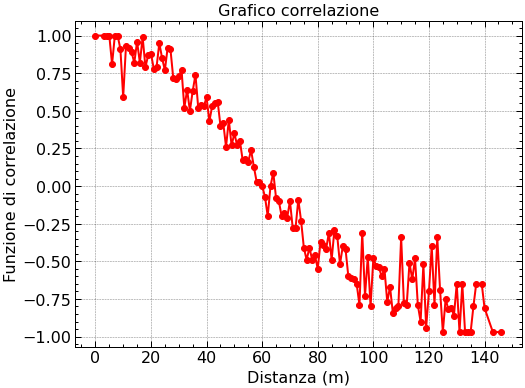

In [23]:
plt.plot(r, cor, marker = "o", color = 'red')
plt.title(" Grafico correlazione ")
plt.xlabel("Distanza (m)") 
plt.ylabel("Funzione di correlazione")
plt.show()

Salvo i valori di r e correlation(r) in un file di testo

In [235]:
file_cor = open("Correlazione.txt", "a+")
for i in range(cor.size):
    file_cor.write(str(r[i]) + " " + str(cor[i]) + "\n")
file_cor.close()      

Rappresentazione volume uccelli ad un certo step t

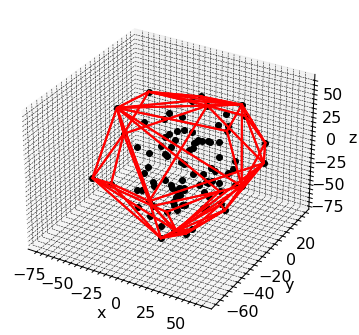

In [24]:
pts = pos_at_step(view_step,file_pos_tot)
hull = ConvexHull(pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

Calcolo polarizzazione ad un certo step:

![Polarizzazione](Img/Polarizzazione.png)

In [39]:
print(polarization_at_step(view_step, file_vel_tot))

0.9616440514456098


In [40]:
#Nomalizzo le velocità medie
VelNorm = velMedia / np.linalg.norm(velMedia)

Calcolo l'anisotropia per ogni step:

In [41]:
step = 0
ucc = 0
anisotropy = np.zeros((steps, birds))
for i in range(steps * birds):
    vel_step = vel_at_step(step, file_vel_tot)
    pos_step = pos_at_step(step, file_pos_tot)
    
    anisotropy[step][ucc] = anisotropia(vel_step, pos_step)
    ucc += 1
    if ucc == birds:
        ucc = 0
        step += 1

/tmp/ipykernel_193971/2020662974.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  anisotropy[step][ucc] = anisotropia(vel_step, pos_step)


Salvo risultati dell'anisotropia in un file di testo

In [154]:
file_ani = open("Anisotropia.txt", "a+")
for i in range(steps):
    for j in range(birds):
        file_ani.write(str(anisotropy[i][j]) + "\n")
file_ani.close()      

Stampo grafico anisotropia

In [25]:
#Grafico anisotropia
plt.plot(file_times, anisotropy, marker = "o", color = 'red', linewidth = 1, markersize = 0.11)
plt.title("Grafico Anisotropia - Tempo")
plt.xlabel("Tempo (secondi)") 
plt.ylabel("Anisotropia")

plt.show()

NameError: name 'anisotropy' is not defined

Calcolo modulo velocità media per ogni uccello ad ogni step

In [27]:
velMod_tot = np.linalg.norm(file_vel_tot, axis = 2)

Stampo grafico del modulo della velocità per ogni uccello - ogni step

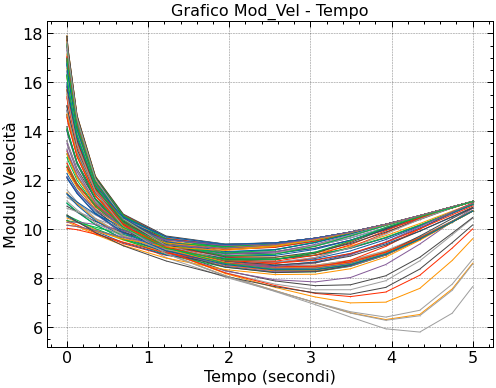

In [29]:
plt.plot(file_times, velMod_tot, marker = "o", linewidth = 1, markersize = 0.11)
plt.title("Grafico Mod_Vel - Tempo")
plt.xlabel("Tempo (secondi)") 
plt.ylabel("Modulo Velocità")
plt.show()

Partiziono i vari moduli della velocità degli uccelli in 50 bins e stampo il relativo istogramma

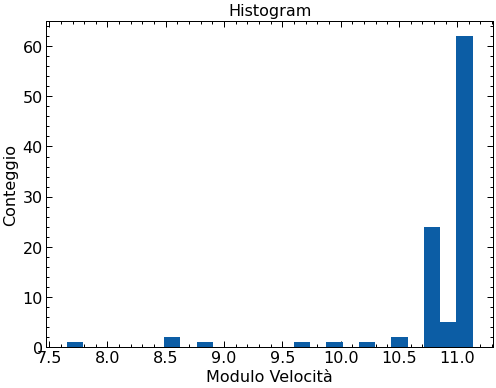

In [40]:
ModVelUcc = np.linalg.norm(vel_at_step(view_step, file_vel_tot), axis = 1)
minMod = min(ModVelUcc.reshape(-1, 1))
maxMod = max(ModVelUcc.reshape(-1, 1))

plt.hist(ModVelUcc, bins = 25)
plt.xlabel("Modulo Velocità")
plt.ylabel("Conteggio")
plt.title("Histogram")

plt.show()

Calcolo e stampo il grafico del modulo della velocità media di tutti gli uccelli ad ogni istante di tempo

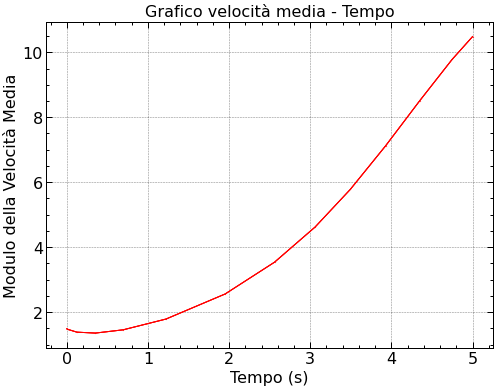

In [39]:
vel_media_mod_tot = np.zeros((steps, ndim))

for j in range(steps):
    vel_media_mod_tot[j] = np.linalg.norm(vel_media_at_step(j,file_vel_tot))
    
plt.plot(file_times, vel_media_mod_tot, marker = "o", color = 'red', linewidth = 1, markersize = 0.11)
plt.title("Grafico velocità media - Tempo")
plt.xlabel("Tempo (s)") 
plt.ylabel("Modulo della Velocità Media")
#plt.ylim(2,3)
plt.show()

Grafico polarizzazione per tutti gli steps

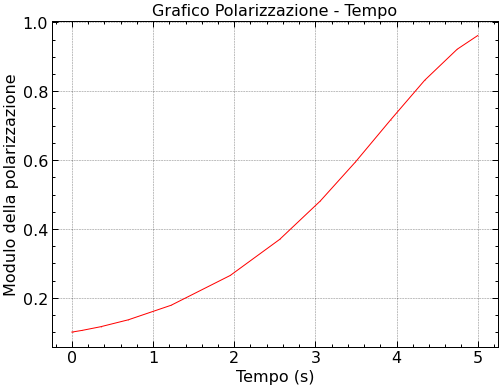

In [37]:
pol_tot = np.zeros((steps))

for j in range(file_times.size):
    pol_tot[j] = polarization_at_step(j, file_vel_tot)
    
plt.plot(file_times, pol_tot, marker = "o", color = 'red', linewidth = 1, markersize = 0.11)
plt.title("Grafico Polarizzazione - Tempo")
plt.xlabel("Tempo (s)") 
plt.ylabel("Modulo della polarizzazione")
plt.show()

Calcolo modulo differenza massimo tra le posizione di tutti gli uccelli ad un dato step

In [32]:
pos_step = pos_at_step(view_step, file_pos_tot)
max_pos = 0

for i in range(birds):
    for j in range(birds):
        if i != j:
            diffij = np.linalg.norm(pos_step[i] - pos_step[j])
            if diffij > max_pos:
                max_pos = diffij               
print(max_pos)

145.59741163399335


Calcolo formule come da figura:

![Formule](Img/formule1.jpg)

In [21]:
pox_step = pos_at_step(view_step, file_pos_tot)
vex_step = vel_at_step(view_step, file_vel_tot)
som_vex = 0
som_pox = 0

for i in range(birds):
    for j in range(birds):
        if i != j:
            dif_vex = pow(np.linalg.norm(vex_step[i] - vex_step[j]), 2)
            dif_pos = pow(np.linalg.norm(pos_step[i] - pos_step[j]), 2)
            som_vex += dif_vex
            som_pox += dif_pos
            
Tetax = som_pox / 2
Deltav = som_vex / 2